In [ ]:
import tensorflow as tf

print("Version de TensorFlow :", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"{len(gpus)} GPU(s) détecté(s) :")
    for gpu in gpus:
        print(gpu)
else:
    print("Aucun GPU détecté.")


Version de TensorFlow : 2.10.1
1 GPU(s) détecté(s) :
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
file_path = "Dataset/Training/all_data.csv"
all_data = pd.read_csv(file_path)
all_data['dateTime'] = pd.to_datetime(all_data['dateTime'])
all_data.drop('TotalCons', axis=1, inplace=True)
all_data.head()


,dateTime,FactoryCons,factory,month,day,hour,minute,day_of_week
0,2019-03-01,1164.80,Cement_1,3,1,0,0,4
1,2019-03-01,369.60,Cement_2,3,1,0,0,4
2,2019-03-01,86.40,Forge_1,3,1,0,0,4
3,2019-03-01,107.52,Forge_2,3,1,0,0,4
4,2019-03-01,184.32,Metal_1,3,1,0,0,4


In [4]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

all_data_norm = all_data.copy()

scaler = MinMaxScaler()

cols_to_normalize = ['FactoryCons', 'month', 'day', 'hour', 'minute', 'day_of_week']

all_data_norm[cols_to_normalize] = scaler.fit_transform(all_data_norm[cols_to_normalize])


all_data_norm.head(10)


,dateTime,FactoryCons,factory,month,day,hour,minute,day_of_week
0,2019-03-01,0.077828,Cement_1,0.0,0.0,0.0,0.0,0.666667
1,2019-03-01,0.024696,Cement_2,0.0,0.0,0.0,0.0,0.666667
2,2019-03-01,0.005773,Forge_1,0.0,0.0,0.0,0.0,0.666667
3,2019-03-01,0.007184,Forge_2,0.0,0.0,0.0,0.0,0.666667
4,2019-03-01,0.012316,Metal_1,0.0,0.0,0.0,0.0,0.666667
5,2019-03-01,0.036146,Metal_2,0.0,0.0,0.0,0.0,0.666667
6,2019-03-01,0.008659,Metal_3,0.0,0.0,0.0,0.0,0.666667
7,2019-03-01,0.034798,Paper,0.0,0.0,0.0,0.0,0.666667
8,2019-03-01,0.004618,Steel_1,0.0,0.0,0.0,0.0,0.666667
9,2019-03-01,0.668961,Steel_2,0.0,0.0,0.0,0.0,0.666667


In [ ]:

import numpy as np
import pandas as pd

def add_cyclic_features(df, col_name, max_val):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)

all_data_cyclic = all_data.copy()


add_cyclic_features(all_data_cyclic, 'month', 12)
add_cyclic_features(all_data_cyclic, 'day', 31)
add_cyclic_features(all_data_cyclic, 'hour', 24)
add_cyclic_features(all_data_cyclic, 'minute', 60)
add_cyclic_features(all_data_cyclic, 'day_of_week', 7)



In [ ]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = ['month_sin', 'month_cos',
                         'day_sin', 'day_cos',
                         'hour_sin', 'hour_cos',
                         'minute_sin', 'minute_cos',
                         'day_of_week_sin', 'day_of_week_cos',
                         'FactoryCons']

scaler = MinMaxScaler()
all_data_cyclic_norm = all_data_cyclic.copy()
all_data_cyclic_norm[features_to_normalize] = scaler.fit_transform(all_data_cyclic[features_to_normalize])

all_data_cyclic_norm.head()

,dateTime,FactoryCons,factory,month,day,hour,minute,day_of_week,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos
0,2019-03-01,0.077828,Cement_1,3,1,0,0,4,1.0,1.0,0.600779,0.989739,0.5,1.0,0.5,1.0,0.277479,0.0
1,2019-03-01,0.024696,Cement_2,3,1,0,0,4,1.0,1.0,0.600779,0.989739,0.5,1.0,0.5,1.0,0.277479,0.0
2,2019-03-01,0.005773,Forge_1,3,1,0,0,4,1.0,1.0,0.600779,0.989739,0.5,1.0,0.5,1.0,0.277479,0.0
3,2019-03-01,0.007184,Forge_2,3,1,0,0,4,1.0,1.0,0.600779,0.989739,0.5,1.0,0.5,1.0,0.277479,0.0
4,2019-03-01,0.012316,Metal_1,3,1,0,0,4,1.0,1.0,0.600779,0.989739,0.5,1.0,0.5,1.0,0.277479,0.0


In [ ]:
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

weekly_data = all_data.groupby(['factory', 'day_of_week']).agg({'FactoryCons': 'mean'}).reset_index()

factories = weekly_data['factory'].unique()
time_series_data = []

for factory in factories:
    factory_data = weekly_data[weekly_data['factory'] == factory]
    factory_data = factory_data.set_index('day_of_week').reindex(range(0, 7))
    time_series_data.append(factory_data['FactoryCons'].fillna(0).values)  

X = to_time_series_dataset(time_series_data)

scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_scaled = scaler.fit_transform(X)


In [ ]:
from tslearn.clustering import TimeSeriesKMeans

k_optimal = 4

model = TimeSeriesKMeans(n_clusters=k_optimal, metric="softdtw", verbose=True, random_state=42)
y_pred = model.fit_predict(X_scaled)

factories = weekly_data['factory'].unique()  
for i, factory in enumerate(factories):
    print(f"Factory: {factory}, Cluster: {y_pred[i]}")


27.127 --> 32.357 --> 32.583 --> 32.583 --> 32.583 --> 32.583 --> 32.583 --> 32.583 --> 32.583 --> 
Factory: Cement_1, Cluster: 1
Factory: Cement_2, Cluster: 1
Factory: Forge_1, Cluster: 0
Factory: Forge_2, Cluster: 3
Factory: Metal_1, Cluster: 0
Factory: Metal_2, Cluster: 2
Factory: Metal_3, Cluster: 0
Factory: Paper, Cluster: 3
Factory: Steel_1, Cluster: 0
Factory: Steel_2, Cluster: 1


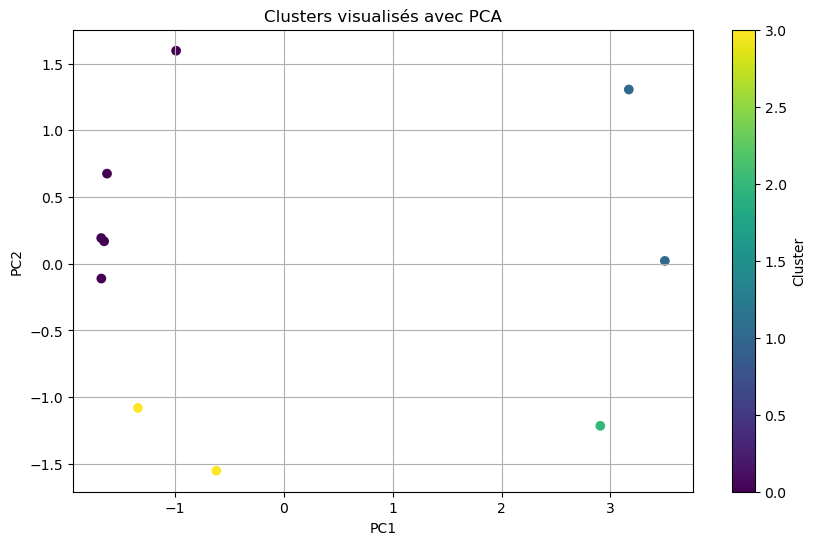

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flattened)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_flattened)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters visualisés avec PCA')
plt.grid(True)
plt.show()


In [ ]:
clusters = {
    0: ['Forge_1', 'Metal_1', 'Metal_3', 'Steel_1'],
    1: ['Cement_1', 'Cement_2', 'Steel_2'],
    2: ['Metal_2'],
    3: ['Forge_2', 'Paper']
}

all_data_0 = all_data[all_data['factory'].isin(clusters[0])]
all_data_1 = all_data[all_data['factory'].isin(clusters[1])]
all_data_2 = all_data[all_data['factory'].isin(clusters[2])]
all_data_3 = all_data[all_data['factory'].isin(clusters[3])]

print("DataFrame for Cluster 0:", all_data_0.shape)
print("DataFrame for Cluster 1:", all_data_1.shape)
print("DataFrame for Cluster 2:", all_data_2.shape)
print("DataFrame for Cluster 3:", all_data_3.shape)


DataFrame for Cluster 0: (1232640, 8)
DataFrame for Cluster 1: (924480, 8)
DataFrame for Cluster 2: (308160, 8)
DataFrame for Cluster 3: (616320, 8)


In [13]:
all_data_0.head()

,dateTime,FactoryCons,factory,month,day,hour,minute,day_of_week
2,2019-03-01 00:00:00,86.40,Forge_1,3,1,0,0,4
4,2019-03-01 00:00:00,184.32,Metal_1,3,1,0,0,4
6,2019-03-01 00:00:00,129.60,Metal_3,3,1,0,0,4
8,2019-03-01 00:00:00,69.12,Steel_1,3,1,0,0,4
12,2019-03-01 00:01:00,86.40,Forge_1,3,1,0,1,4
